In [164]:
# -*- coding: utf-8 -*-
__author__ = 'NadyaMotina'

import time
import json
import codecs
import pandas
import operator
import igraph
import community
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from itertools import combinations
from transliterate import translit

In [2]:
start_time = time.time()
#model = Word2Vec.load_word2vec_format('../../Models/webcorpora.model.bin', binary=True)
model = Word2Vec.load_word2vec_format('../../Models/ruscorpora.model.bin', binary=True)
#model = Word2Vec.load_word2vec_format('../../Models/news.model.bin', binary=True)
print 'Model loaded successfully. It took ', time.time() - start_time, ' seconds'

Model loaded successfully. It took  6.93864417076  seconds


# networkx

In [35]:
def build_rng(word, model, topn=10, threshold=0):
    # 1) find N most similar words from the model
    # 2) for each combination of 2 words find if there is some other neighbor in between them
    #    * if there is no such word: add an edge
    # output: graph object
    wg = nx.Graph()
    neighbors = model.most_similar(word, topn=topn)
    neighbors.append((word, 1.0))
    for pair in combinations(neighbors, 2):
        word0 = pair[0][0]
        word1 = pair[1][0]
        similarity = model.similarity(word0, word1)
        if similarity > threshold:
            remaining = [vertex for vertex in neighbors if vertex != pair[0] \
                         and vertex != pair[1]]
            for vertex in remaining:
                drawedge = True
                candidate = vertex[0]
                if model.similarity(candidate, word1) > similarity \
                and model.similarity(candidate, word0) > similarity:
                    drawedge = False
                    break
                if drawedge == True:
                    # Cyrillic symbols cause error for graph plotting
                    # so we need to transliterate words
                    w1 = translit(pair[0][0], 'ru', reversed=True) 
                    w2 = translit(pair[1][0], 'ru', reversed=True)
                    wg.add_edge(w1, w2, weight=similarity)
    # remove the starting node to see only resulting clusters
    word_clustering = nx.clustering(wg, translit(word, 'ru', reversed=True))
    wg.remove_node(translit(word, 'ru', reversed=True))
    return wg, translit(word, 'ru', reversed=True), word_clustering
 
def draw_rng(wg):
    # draw high cosine similarity edges bold
    # and low cosine similarity edges faint and dashed
    # print nx.info(wg)    
    threshold = 0.45
    elarge=[(u,v) for (u,v,d) in wg.edges(data=True) if d['weight'] > threshold]
    esmall=[(u,v) for (u,v,d) in wg.edges(data=True) if d['weight'] <= threshold]
    plt.figure(figsize=(10,10))
    plt.axis('off')
    pos = nx.spring_layout(wg)
    partition = louvain_communities(wg)
    values = [partition.get(node) for node in wg.nodes()]
    nx.draw_networkx_nodes(wg, pos, node_size = 200, node_color = values)
    nx.draw_networkx_edges(wg, pos, edgelist=elarge, width=4, alpha=0.7, edge_color='g')
    nx.draw_networkx_edges(wg, pos, edgelist=esmall, width=4, alpha=0.2, edge_color='b', style='dashed')
    nx.draw_networkx_labels(wg, pos, font_size=16, font_family='sans-serif')
    plt.show()
    
def louvain_communities(graph):
    # Compute the partition of the graph nodes which maximises the modularity  
    # using the Louvain heuristices
    partition = community.best_partition(graph)
    for i in list(set(partition.values())):
        print i, '_________________________'
        for j in partition:
            if partition[j] == i:
                print translit(j, 'ru')
    return partition

0.563039817326
0 _________________________
дорого_АДВ
недешевый_А
привередливый_А
шикарный_А
недорогой_А
дешевый_А
1 _________________________
драгоценный_А
даритЬ_В
бесценный_А
подаритЬ_В
любимый_А
любимый_С
любимая_С
2 _________________________
лиичка_С
пекочка_С
карлито_С
имянинник_С
лиленок_С
женуличка_С
3 _________________________
здравствоватЬ_В
уважаемый_А
миленЬкий_А
заобожатЬ_В
любезный_А
леблЬ_С
милый_А
4 _________________________
хороший_А
разлюбезный_А
мосес_С
небаловатЬ_В
желанный_А
уборочЬе_С
лютча_С
близкий_А
разнообразный_А


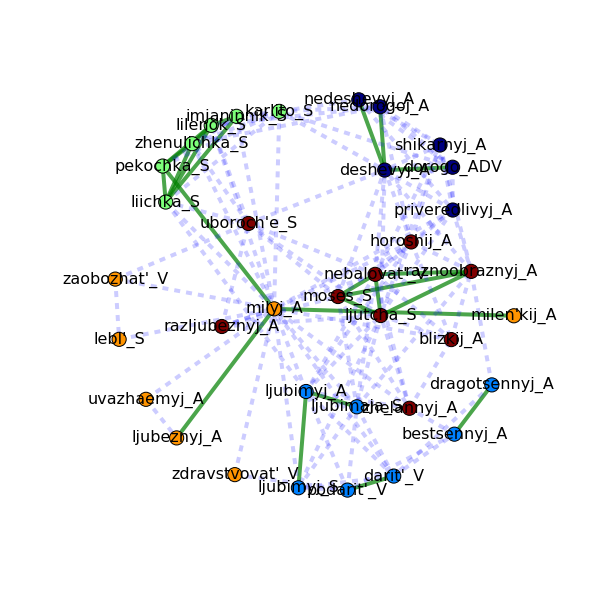

In [51]:
# model can read only words with a POS-tag (S=noun, V=verb, A=adjective)

word = 'дорогой_A'.decode('utf8')
graph, node, word_clustering = build_rng(word, model, topn=35, threshold=0.25)
print nx.average_clustering(graph)
draw_rng(graph)

## save a graph for Gephi
# nx.write_graphml(graph, "test.graphml", encoding='utf-8') 

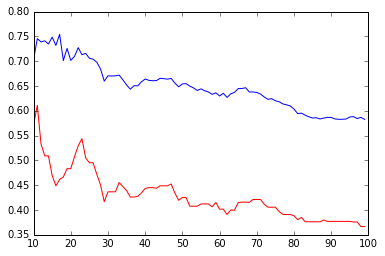

In [32]:
word = 'ручка_S'.decode('utf8')
topn = range(10,100)
word_clusters = []
graph_clusters = []

for i in topn:
    graph, node, word_clustering = build_rng(word, model, topn=i)
    word_clusters.append(word_clustering)
    graph_clusters.append(nx.average_clustering(graph))
    #draw_rng(graph)
    
plt.plot(topn, word_clusters, 'r')
plt.plot(topn, graph_clusters, 'b')
plt.show()

In [33]:
graph, node, word_clustering = build_rng(word, model, topn=200)
print word_clustering
print nx.average_clustering(graph)

0.327685950413
0.525186519208


# igraph

In [52]:
def i_build_rng(word, model, topn=10, threshold=0):
    # 1) find N most similar words from the model
    # 2) for each combination of 2 words find if there is some other neighbor in between them
    #    * if there is no such word: add an edge
    # output: graph object
    wg = igraph.Graph()
    neighbors = model.most_similar(word, topn=topn)
    neighbors.append((word, 1.0))
    for pair in combinations(neighbors, 2):
        word0 = pair[0][0]
        word1 = pair[1][0]
        similarity = model.similarity(word0, word1)
        if similarity > threshold:
            remaining = [vertex for vertex in neighbors if vertex != pair[0] \
                         and vertex != pair[1]]
            for vertex in remaining:
                drawedge = True
                candidate = vertex[0]
                if model.similarity(candidate, word1) > similarity \
                and model.similarity(candidate, word0) > similarity:
                    drawedge = False
                    break
                if drawedge == True:
                    w1 = pair[0][0].encode('utf8') 
                    w2 = pair[1][0].encode('utf8') 
                    try: wg.vs.find(w1)
                    except: wg.add_vertices(w1)
                    try: wg.vs.find(w2)
                    except: wg.add_vertices(w2)
                    if wg.are_connected(w1, w2) is False:
                        wg.add_edge(w1, w2, weight=similarity)
    # remove the starting node to see only resulting clusters
    wg.delete_vertices(word.encode('utf8') )
    return wg, word.encode('utf8') 

0.480749219563
Clustering with 40 elements and 4 clusters
[0] пальчик_S, ладонь_S, сиська_S, рука_S,
    локоток_S, ладошка_S, ручка_S, ручонка_S,
    кулачок_S, мизинчик_S
[1] палец_S, ухо_S, подбородок_S, пятерня_S,
    губа_S, суставчик_S, перст_S, нос_S
[2] указательный_A, наманикюренный_A,
    ноготь_S, кончик_S, пилочка_S,
    послюнявить_V, пясть_S, щепоть_S,
    вмятинка_S, обрубковатый_A, соломина_S,
    заклещило_S
[3] запястье_S, кисть_S, ступня_S, лодыжка_S,
    лапка_S, коленка_S, ключица_S, нога_S,
    локоть_S, ягодица_S


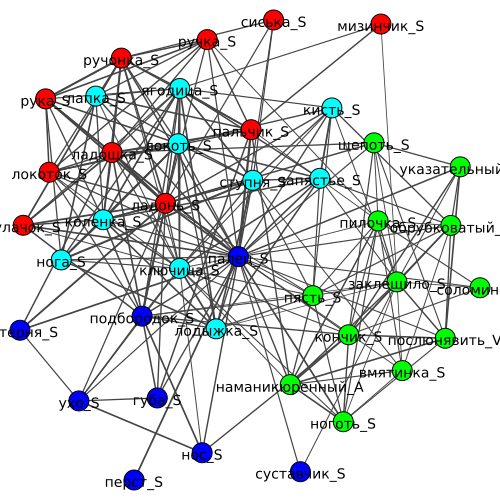

In [90]:
word = 'мизинец_S'.decode('utf8')
graph, node = i_build_rng(word, model, topn=40, threshold=0.2)
print graph.transitivity_undirected()
color_list = ['red','blue','green','cyan','pink','orange','grey','yellow','white','black','purple']
graph.vs["label"] = graph.vs["name"]
community = graph.community_multilevel()
print community
layout = graph.layout("kk")
igraph.plot(graph, '../../graph.svg', bbox = (500,500), layout = layout, labels='label',\
            vertex_color=[color_list[x] for x in community.membership], \
           edge_width = [i*3 for i in graph.es['weight']])

In [21]:
community = graph.community_multilevel()
print community

Clustering with 15 elements and 3 clusters
[0] вселенная_S, царство_S, окружающее_S
[1] мироздание_S, реальность_S, природа_S,
    действительность_S, бытие_S, тварный_A,
    существо_S, жизнь_S
[2] человечество_S, страна_S, европа_S, россия_S


In [22]:
community = graph.community_label_propagation()
print community

Clustering with 15 elements and 2 clusters
[0] вселенная_S, мироздание_S, реальность_S,
    природа_S, действительность_S, царство_S,
    бытие_S, тварный_A, существо_S,
    окружающее_S, жизнь_S
[1] человечество_S, страна_S, европа_S, россия_S


In [23]:
community = graph.community_leading_eigenvector()
print community

Clustering with 15 elements and 2 clusters
[0] вселенная_S, мироздание_S, реальность_S,
    природа_S, действительность_S, царство_S,
    бытие_S, тварный_A, существо_S,
    окружающее_S, жизнь_S
[1] человечество_S, страна_S, европа_S, россия_S


## Evaluation
#### Step 1. single / multiple